In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weatherhistory/weatherHistory.csv


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/kaggle/input/weatherhistory/weatherHistory.csv')

# Select relevant columns
data = data[['Formatted Date', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)', 'Daily Summary']]

# Convert the date column to datetime
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'])

# Set the date column as the index
data.set_index('Formatted Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']] = scaler.fit_transform(data[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']])

# Encode the categorical output
label_encoder = LabelEncoder()
data['Daily Summary'] = label_encoder.fit_transform(data['Daily Summary'])

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Convert the data to numpy arrays
train = train.values
test = test.values

# Create the dataset for the RNN and LSTM models
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Assuming the target is the last column (Daily Summary)
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))


/tmp/ipykernel_36/1162295619.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Formatted Date'] = pd.to_datetime(data['Formatted Date'])


In [21]:
data.head()

,Temperature (C),Humidity,Wind Speed (km/h),Pressure (millibars),Daily Summary
Formatted Date,,,,,
2006-04-01 00:00:00+02:00,0.506975,0.89,0.221130,0.970135,197
2006-04-01 01:00:00+02:00,0.505085,0.86,0.223399,0.970613,197
2006-04-01 02:00:00+02:00,0.505445,0.89,0.061523,0.970909,197
2006-04-01 03:00:00+02:00,0.487805,0.83,0.220877,0.971358,197
2006-04-01 04:00:00+02:00,0.495365,0.83,0.172970,0.971454,197


In [22]:
X_train

array([[[0.50697507, 0.89      , 0.2211296 , 0.97013513]],

       [[0.50508505, 0.86      , 0.22339889, 0.97061297]],

       [[0.50544505, 0.89      , 0.06152295, 0.97090923]],

       ...,

       [[0.38169382, 0.93      , 0.0910237 , 0.98169881]],

       [[0.3798038 , 0.93      , 0.10085729, 0.98142166]],

       [[0.37233372, 0.92      , 0.0501765 , 0.9811254 ]]])

In [24]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.utils import to_categorical

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(look_back, X_train.shape[2])))
rnn_model.add(Dense(y_train.shape[1], activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the RNN model
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
2412/2412 - 6s - 2ms/step - accuracy: 0.1897 - loss: 3.4554
Epoch 2/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2010 - loss: 3.2522
Epoch 3/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2013 - loss: 3.2158
Epoch 4/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2022 - loss: 3.2016
Epoch 5/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2022 - loss: 3.1927
Epoch 6/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2035 - loss: 3.1868
Epoch 7/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2041 - loss: 3.1813
Epoch 8/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2039 - loss: 3.1758
Epoch 9/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2051 - loss: 3.1713
Epoch 10/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2045 - loss: 3.1671
Epoch 11/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2058 - loss: 3.1621
Epoch 12/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2057 - loss: 3.1588
Epoch 13/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2061 - loss: 3.1548
Epoch 14/50
2412/2412 - 3s - 1ms/step - accuracy: 0.2068 - loss: 3.1522
E

In [25]:
from keras.layers import LSTM

# Build the LSTM model
lstm_model_1 = Sequential()
lstm_model_1.add(LSTM(50, input_shape=(look_back, X_train.shape[2])))
lstm_model_1.add(Dense(y_train.shape[1], activation='softmax'))
lstm_model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
lstm_model_1.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
2412/2412 - 10s - 4ms/step - accuracy: 0.1905 - loss: 3.5554
Epoch 2/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2006 - loss: 3.2714
Epoch 3/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2017 - loss: 3.2231
Epoch 4/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2021 - loss: 3.2080
Epoch 5/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2035 - loss: 3.1983
Epoch 6/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2031 - loss: 3.1899
Epoch 7/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2048 - loss: 3.1815
Epoch 8/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2041 - loss: 3.1747
Epoch 9/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2048 - loss: 3.1687
Epoch 10/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2054 - loss: 3.1633
Epoch 11/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2064 - loss: 3.1584
Epoch 12/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2071 - loss: 3.1534
Epoch 13/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2067 - loss: 3.1490
Epoch 14/50
2412/2412 - 8s - 3ms/step - accuracy: 0.2070 - loss: 3.1453


In [28]:
# Build the Stacked LSTM model
lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
lstm_model_2.add(LSTM(50))
lstm_model_2.add(Dense(y_train.shape[1], activation='softmax'))
lstm_model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Stacked LSTM model
lstm_model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)



Epoch 1/50
2412/2412 - 13s - 5ms/step - accuracy: 0.1920 - loss: 3.5274
Epoch 2/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2000 - loss: 3.2794
Epoch 3/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2038 - loss: 3.2096
Epoch 4/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2044 - loss: 3.1933
Epoch 5/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2048 - loss: 3.1833
Epoch 6/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2058 - loss: 3.1738
Epoch 7/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2069 - loss: 3.1610
Epoch 8/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2076 - loss: 3.1436
Epoch 9/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2086 - loss: 3.1253
Epoch 10/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2099 - loss: 3.1089
Epoch 11/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2103 - loss: 3.0944
Epoch 12/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2117 - loss: 3.0820
Epoch 13/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2117 - loss: 3.0715
Epoch 14/50
2412/2412 - 11s - 4ms/step - accuracy: 0.2127 - 

In [29]:
from keras.layers import Bidirectional

# Build the Bidirectional LSTM model
lstm_model_3 = Sequential()
lstm_model_3.add(Bidirectional(LSTM(50), input_shape=(look_back, X_train.shape[2])))
lstm_model_3.add(Dense(y_train.shape[1], activation='softmax'))
lstm_model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Bidirectional LSTM model
lstm_model_3.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2412/2412 - 13s - 5ms/step - accuracy: 0.1931 - loss: 3.4804
Epoch 2/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2014 - loss: 3.2443
Epoch 3/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2025 - loss: 3.2123
Epoch 4/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2025 - loss: 3.1985
Epoch 5/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2032 - loss: 3.1878
Epoch 6/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2047 - loss: 3.1788
Epoch 7/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2054 - loss: 3.1714
Epoch 8/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2060 - loss: 3.1645
Epoch 9/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2067 - loss: 3.1581
Epoch 10/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2068 - loss: 3.1522
Epoch 11/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2076 - loss: 3.1472
Epoch 12/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2082 - loss: 3.1432
Epoch 13/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2080 - loss: 3.1398
Epoch 14/50
2412/2412 - 11s - 5ms/step - accuracy: 0.2082 - 

In [32]:
# Make predictions
rnn_predictions = rnn_model.predict(X_test)
lstm_predictions_1 = lstm_model_1.predict(X_test)
lstm_predictions_2 = lstm_model_2.predict(X_test)
lstm_predictions_3 = lstm_model_3.predict(X_test)

# Convert predictions back to label encoding
rnn_predictions = np.argmax(rnn_predictions, axis=1)
lstm_predictions_1 = np.argmax(lstm_predictions_1, axis=1)
lstm_predictions_2 = np.argmax(lstm_predictions_2, axis=1)
lstm_predictions_3 = np.argmax(lstm_predictions_3, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
rnn_accuracy = accuracy_score(y_test_labels, rnn_predictions)
lstm_accuracy_1 = accuracy_score(y_test_labels, lstm_predictions_1)
lstm_accuracy_2 = accuracy_score(y_test_labels, lstm_predictions_2)
lstm_accuracy_3 = accuracy_score(y_test_labels, lstm_predictions_3)

# Print accuracy
print(f"RNN Accuracy: {rnn_accuracy}")
print(f"LSTM Model 1 Accuracy: {lstm_accuracy_1}")
print(f"LSTM Model 2 Accuracy: {lstm_accuracy_2}")
print(f"LSTM Model 3 Accuracy: {lstm_accuracy_3}")

# Get the unique classes from the test labels
unique_classes = np.unique(y_test_labels)

# Print classification report for RNN
print("RNN Classification Report:")
print(classification_report(y_test_labels, rnn_predictions, labels=unique_classes, target_names=label_encoder.inverse_transform(unique_classes)))

# Print classification report for LSTM Model 1
print("LSTM Model 1 Classification Report:")
print(classification_report(y_test_labels, lstm_predictions_1, labels=unique_classes, target_names=label_encoder.inverse_transform(unique_classes)))

# Print classification report for LSTM Model 2
print("LSTM Model 2 Classification Report:")
print(classification_report(y_test_labels, lstm_predictions_2, labels=unique_classes, target_names=label_encoder.inverse_transform(unique_classes)))

# Print classification report for LSTM Model 3
print("LSTM Model 3 Classification Report:")
print(classification_report(y_test_labels, lstm_predictions_3, labels=unique_classes, target_names=label_encoder.inverse_transform(unique_classes)))




603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RNN Accuracy: 0.29903053553838976
LSTM Model 1 Accuracy: 0.2760640779719011
LSTM Model 2 Accuracy: 0.2947794079527192
LSTM Model 3 Accuracy: 0.283373943698481
RNN Classification Report:
                                                                                                                  precision    recall  f1-score   support

                                                                 Breezy in the morning and foggy in the evening.       0.00      0.00      0.00        24
                                                Breezy in the morning and mostly cloudy starting in the evening.       0.00      0.00      0.00        24
                                                          Breezy overnight and mostly cloudy throughout the day.       0.00      0.00      0.00        24
                             Bree

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

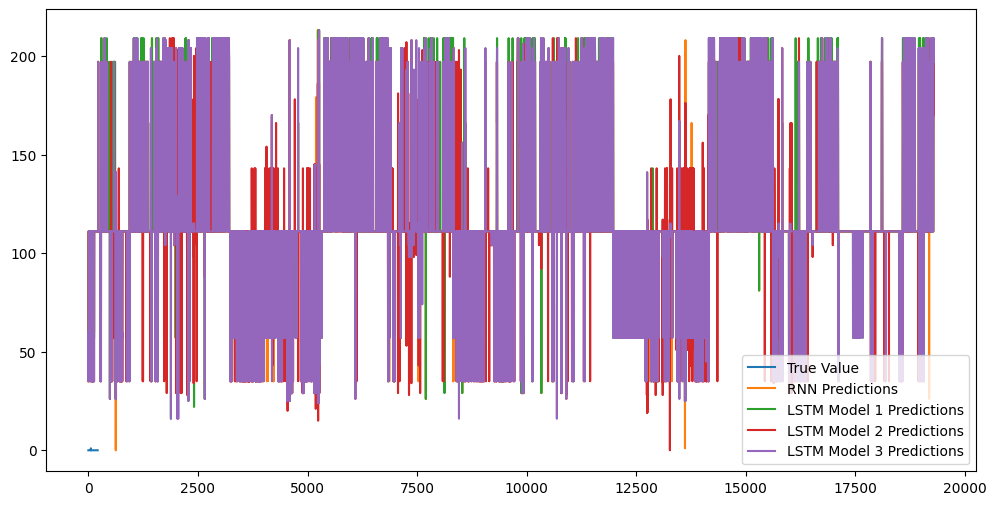

In [33]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test[0], label='True Value')
plt.plot(rnn_predictions, label='RNN Predictions')
plt.plot(lstm_predictions_1, label='LSTM Model 1 Predictions')
plt.plot(lstm_predictions_2, label='LSTM Model 2 Predictions')
plt.plot(lstm_predictions_3, label='LSTM Model 3 Predictions')
plt.legend()
plt.show()
